<a href="https://colab.research.google.com/github/alicezil/38615-Lab-1/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 38615 Lab 1: Exploratory Data Anlysis

You will have to perform EDA analysis:

*   Load data, prepare for analysis, process if necessary
*   Analyze types of data
*   Find and process missing and erroneous features
*   Find outliers (if any)
*   Find highly correlated variables (if any).
*   Find if the target variable is correlated with any features.
*   Use PCA to plot data in 2D and color code by the target property. Do you    see any patterns?
*   Prepare a short write-up describing your processing technics and choices above.

Bonus Qs:
*   Use any non-linear dimensionality reduction method. Plot data in 2D and color code by the target property. Compare observed picture with PCA.
*   Surprise me! Uncover hidden patterns and find non-trivial relationships in the data

# 1. Loading and Preparing Data for Analysis

1.1 Importing the necessary libraries:

In [74]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline 
sns.set(color_codes=True)

1.2 Loading the data into the data frame:

In [75]:
df = pd.read_csv("/content/lab1_dataset.csv")
df.shape

(2000, 552)

1.3 Basic data preperation:

In [49]:
# removing duplicate rows if there are any
df = df.drop_duplicates()    

# dropping the missing values
df = df.dropna()             

# dropping not numerical columns
for col in df:
    if df[col].dtypes != 'float64' and df[col].dtypes != 'int64':
      df = df.drop([col],axis=1)

df.shape

(1900, 549)

1.4 Removing outliers:

In [79]:
#getting a summary table that includes mean and standard deviation
df_summary = df.describe(include = 'all')

#using the standard deviation to remove outliers (where outlier = 4 standard devs away from the mean)
for col in df:
  std = df_summary[col]['std']
  mean = df_summary[col]['mean']
  if df[col].dtypes == 'int64' or df[col].dtypes == 'float62':
    for i in df.index:
      if ((df[col][i] < (mean - 4*std)) or (df[col][i] > (mean + 4*std))):
        df = df.drop([i])

df.shape

(1578, 240)

#2. Finding Correlation in Data

2.1 Constructing a correlation matrix

In [77]:
#create correlation matrix
corr_matrix = df.corr().abs()

2.2 Removing highly correlated data

In [78]:
#isolate upper triangle (for lack of repetition)
upper_triangle = corr_matrix.where((np.triu(np.ones(corr_matrix.shape), k=1) + 
                           np.tril(np.ones(corr_matrix.shape), k=-1)).astype(bool))

#make a list of columns with correlation larger than .97
drop_list = []
for col in upper_triangle.columns:
  if any(upper_triangle[col] > 0.97):
    drop_list.append(col)

#drop all the columns from the list
df.drop(drop_list, axis=1, inplace=True)

df.shape

(1714, 240)

#3. Establish Target Variable and Plot it's Distribtuion

3.1 Establishing a target variable

In [53]:
#show top of the data
df.head()

,experimental_proprty,nHetero,nX,C2SP3,NaasN,nFAHRing,AATS3d,nHBDon,nAcid,PEOE_VSA8,...,ATSC6d,ATS5dv,NsssCH,AATSC2v,PEOE_VSA12,IC1,EState_VSA5,AATSC1dv,nFARing,n6Ring
0,3.54,5,1,0,1,0,3.127273,0,0,43.936717,...,-4.444444,222.888889,0,4.021507,0.00000,3.133948,11.204087,1.102539,0,3
1,-1.18,11,0,3,0,1,3.477273,2,1,12.108208,...,-9.756392,736.333333,1,4.393094,5.90718,3.847419,30.657545,0.854039,1,3
2,3.69,5,1,2,0,1,3.400000,0,0,22.989293,...,-3.103725,327.444444,1,5.398449,0.00000,3.524624,17.550396,0.793417,1,2
3,3.37,9,1,3,0,1,3.309735,4,0,17.494432,...,-5.502836,582.777778,2,-0.991896,5.90718,4.110093,16.236696,0.421656,1,2
4,3.10,7,0,2,1,0,2.816000,2,0,18.883484,...,0.297521,510.000000,1,7.240313,5.90718,3.555674,4.681803,1.602810,0,1


The 'experimental_proprty' column sounds like it may be our target variable. Let's get more info on it:

In [54]:
#summary of possible target variable column
df['experimental_proprty'].describe()

count    1630.000000
mean        2.165546
std         1.197310
min        -1.500000
25%         1.390000
50%         2.350000
75%         3.080000
max         4.500000
Name: experimental_proprty, dtype: float64

It seems like the range is quite small since the min is -1.5 and the max is 4.5. If you look at the quartiles they all have a difference of approximately 1 which leads me to believe that if we cast the column to integers instead of floats we can have approximetely 6 sections -1, 0, 1, 2, 3, and 4. This will make the analysis neater and more understandable.

In [55]:
#casting the target variable column to int
df = df.astype({'experimental_proprty':'int'})

#checking that the values are now integers (they are!)
df['experimental_proprty'].head()

0    3
1   -1
2    3
3    3
4    3
Name: experimental_proprty, dtype: int64

3.2 Analyzing distribution of target variable

Text(0.5, 0, 'Value')

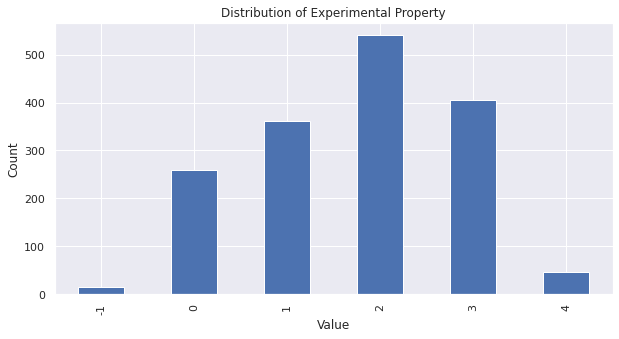

In [56]:
#plotting distribution
df['experimental_proprty'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
plt.title('Distribution of Experimental Property')
plt.ylabel('Count')
plt.xlabel('Value')

The distribution of the target variable is approximatly normal with a slight skew to the left.

#4. Using PCA and Dividing by Target Variable

4.1 Setting and plotting PCA

In [65]:
df_new = df.copy(deep=True)
df_new = df_new.drop(['experimental_proprty'], axis=1)
y = df['experimental_proprty']

#scaling the feature data
scaler = StandardScaler()
df_new = scaler.fit_transform(df_new)


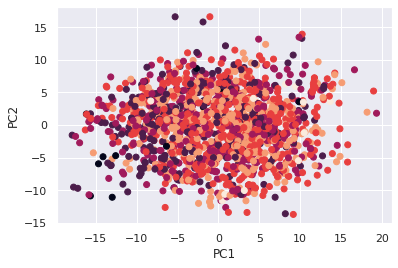

In [66]:
#applying PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_new)

#plotting PCA
plt.scatter(principalComponents[:,0], principalComponents[:,1], c = y)
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

4.2 Setting and plotting Isomap

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


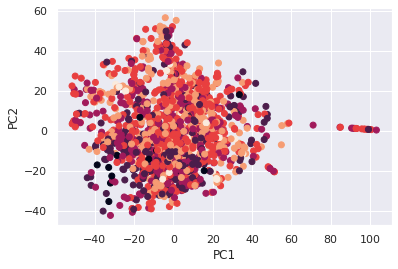

In [67]:
#applying isomap 
isomap = manifold.Isomap(n_neighbors=5, n_components=2)
isomapComponents = isomap.fit_transform(df_new)

#plotting Isomap
plt.scatter(isomapComponents[:,0], isomapComponents[:,1], c = y)
plt.title('Isomap')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

4.3 Setting and plotting tSNE

  with perplexity 5



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


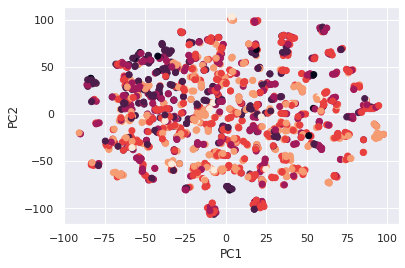

In [69]:
#applying tSNE
tsne = manifold.TSNE(perplexity=5, random_state=42, n_components=2)
tsneComponents = tsne.fit_transform(df_new)

#plotting tSNE
plt.scatter(tsneComponents[:,0], tsneComponents[:,1], c = y)
plt.title('tSNE perplexity = 5')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

  with perpleity 30

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


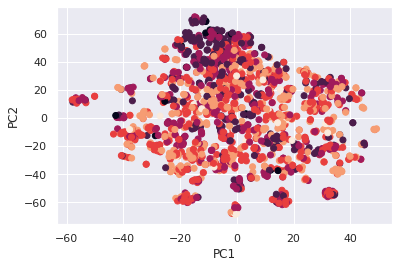

In [70]:
#applying tSNE
tsne = manifold.TSNE(perplexity=30, random_state=42, n_components=2)
tsneComponents = tsne.fit_transform(df_new)

#plotting tSNE
plt.scatter(tsneComponents[:,0], tsneComponents[:,1], c = y)
plt.title('tSNE perplexity = 30')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

with perplexity 50

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


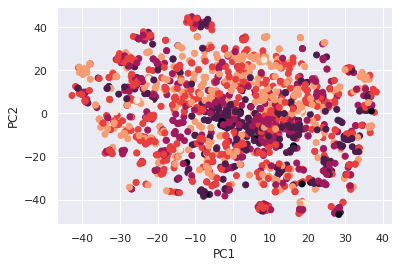

In [71]:
#applying tSNE
tsne = manifold.TSNE(perplexity=50, random_state=42, n_components=2)
tsneComponents = tsne.fit_transform(df_new)

#plotting tSNE
plt.scatter(tsneComponents[:,0], tsneComponents[:,1], c = y)
plt.title('tSNE perplexity = 50')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

  with perplexity 100

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


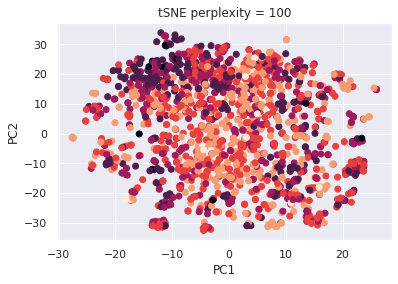

In [73]:
#applying tSNE
tsne = manifold.TSNE(perplexity=100, random_state=42, n_components=2)
tsneComponents = tsne.fit_transform(df_new)

#plotting tSNE
plt.scatter(tsneComponents[:,0], tsneComponents[:,1], c = y)
plt.title('tSNE perplexity = 100')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()